In [1]:
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import matplotlib as mpl
from matplotlib.pyplot import cm

In [3]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [4]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from matplotlib_venn import venn3

## Get GTEx significant associations

In [5]:
sig_eqtl="/cellar/users/mpagadal/Data/gtex/GTEx_Analysis_v8_eQTL_EUR"
files=[x for x in os.listdir(sig_eqtl) if "pairs" in x]

In [6]:
mapping=pd.read_csv("/cellar/users/mpagadal/Data/gtex/GTEx_Analysis_2017-06-05_v8_WholeGenomeSeq_838Indiv_Analysis_Freeze.lookup_table.txt",delimiter="\t")
mp_b38_b37=dict(zip(mapping.variant_id,mapping.variant_id_b37))

In [7]:
#get snp lst
snps=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/snp-tables/immune-microenvironment-nonhla.tsv",delimiter="\t")
snps["assoc"]=snps["snps"]+"_"+snps["file"]
snp_lst=snps["snps"].tolist()+[x.rsplit(":",2)[0]+":"+x.split(":")[3]+":"+x.split(":")[2] for x in snps["snps"].tolist()]


In [8]:
compiled_cis=pd.DataFrame()

for x in files:
    eqtl=pd.read_csv(sig_eqtl+"/"+x,delimiter="\t")
    eqtl["variant_b37"] = eqtl["variant_id"].map(mp_b38_b37)
    eqtl["variant"] = eqtl["variant_b37"].str.split("_").str[0]+":"+eqtl["variant_b37"].str.split("_").str[1]+":"+eqtl["variant_b37"].str.split("_").str[2]+":"+eqtl["variant_b37"].str.split("_").str[3]
    eqtl["cell"]=x.split(".v8")[0]
    eqtl_filt=eqtl[eqtl["variant"].isin(snp_lst)]
    compiled_cis=compiled_cis.append(eqtl_filt)

In [9]:
compiled_cis["gene_id"]=compiled_cis["phenotype_id"].str.split(".").str[0]

In [10]:
with open('/cellar/users/mpagadal/Data/resources/tcga/ensembl_map.json', 'r') as f:
    ensembl_dict = json.load(f)

In [11]:
ensembl_dict={k.split(".")[0]:v for k,v in ensembl_dict.items()}

In [12]:
compiled_cis["gtex gene"]=compiled_cis["gene_id"].map(ensembl_dict)

In [13]:
compiled_cis=compiled_cis.rename(columns={"variant":"snps"})

In [14]:
compiled_cis["assoc"]=compiled_cis["snps"]+"_"+compiled_cis["gtex gene"]

## combine gtex and tcga data frame

In [16]:
gtex_assoc=pd.merge(snps,compiled_cis[["snps","gtex gene","cell","gene_id"]],on="snps",how="left")

In [17]:
cis=gtex_assoc[~(gtex_assoc["cis tss"].isnull())]["assoc"].unique()
trans=gtex_assoc[gtex_assoc["cis tss"].isnull()]["assoc"].unique()

In [18]:
len(cis)

389

In [19]:
len(trans)

93

In [20]:
gtex_cis=gtex_assoc[gtex_assoc["assoc"].isin(cis)]
gtex_cis=gtex_cis[gtex_cis["gtex gene"]==gtex_cis["file"]]["assoc"].unique().tolist()

In [21]:
len(gtex_cis)

171

In [22]:
gtex_trans=gtex_assoc[gtex_assoc["assoc"].isin(trans)]
gtex_trans=gtex_trans[~(gtex_trans["gtex gene"].isnull())]["assoc"].unique().tolist()

In [23]:
len(gtex_trans)

42

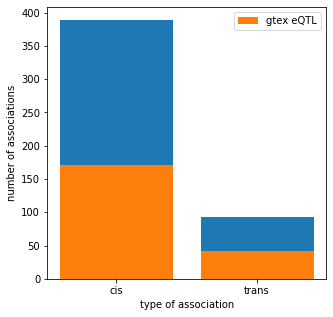

In [24]:
f=plt.figure(figsize=(5,5))
plt.bar(["cis","trans"],[len(cis),len(trans)])
plt.bar(["cis","trans"],[len(gtex_cis),len(gtex_trans)],label="gtex eQTL")
plt.ylabel("number of associations")
plt.xlabel("type of association")
plt.legend()
plt.savefig("gtex.eqtl.pdf")

In [25]:
len(trans)

93

In [26]:
combos=['Kidney_Cortex.KICH',
 'Kidney_Cortex.KIRC',
 'Kidney_Cortex.KIRP',
 'Testis.TGCT',
 'Brain_Hippocampus.GBM',
 'Skin_Sun_Exposed_Lower_leg.SKCM',
 'Ovary.OV',
 'Colon_Transverse.COAD',
 'Adrenal_Gland.ACC',
 'Pancreas.PAAD',
 'Esophagus_Muscularis.ESCA',
 'Stomach.STAD',
 'Thyroid.THCA',
 'Breast_Mammary_Tissue.BRCA',
 'Minor_Salivary_Gland.HNSC',
 'Brain_Anterior_cingulate_cortex_BA24.LGG',
 'Liver.LIHC',
 'Prostate.PRAD',
 'Uterus.UCEC',
 'Lung.LUAD',
 'Lung.LUSC']
gtex_tissues=[x.split(".")[0] for x in combos]

In [27]:
overlap=compiled_cis[compiled_cis["cell"].isin(gtex_tissues+["Whole_Blood"])]

In [37]:
gtex_tissues

['Kidney_Cortex',
 'Kidney_Cortex',
 'Kidney_Cortex',
 'Testis',
 'Brain_Hippocampus',
 'Skin_Sun_Exposed_Lower_leg',
 'Ovary',
 'Colon_Transverse',
 'Adrenal_Gland',
 'Pancreas',
 'Esophagus_Muscularis',
 'Stomach',
 'Thyroid',
 'Breast_Mammary_Tissue',
 'Minor_Salivary_Gland',
 'Brain_Anterior_cingulate_cortex_BA24',
 'Liver',
 'Prostate',
 'Uterus',
 'Lung',
 'Lung']

Pancreas
Kidney_Cortex
Minor_Salivary_Gland
Skin_Sun_Exposed_Lower_leg
Liver
Colon_Transverse
Prostate
Stomach
Adrenal_Gland
Brain_Anterior_cingulate_cortex_BA24
Breast_Mammary_Tissue
Lung
Ovary
Uterus
Thyroid
Testis
Esophagus_Muscularis
Brain_Hippocampus


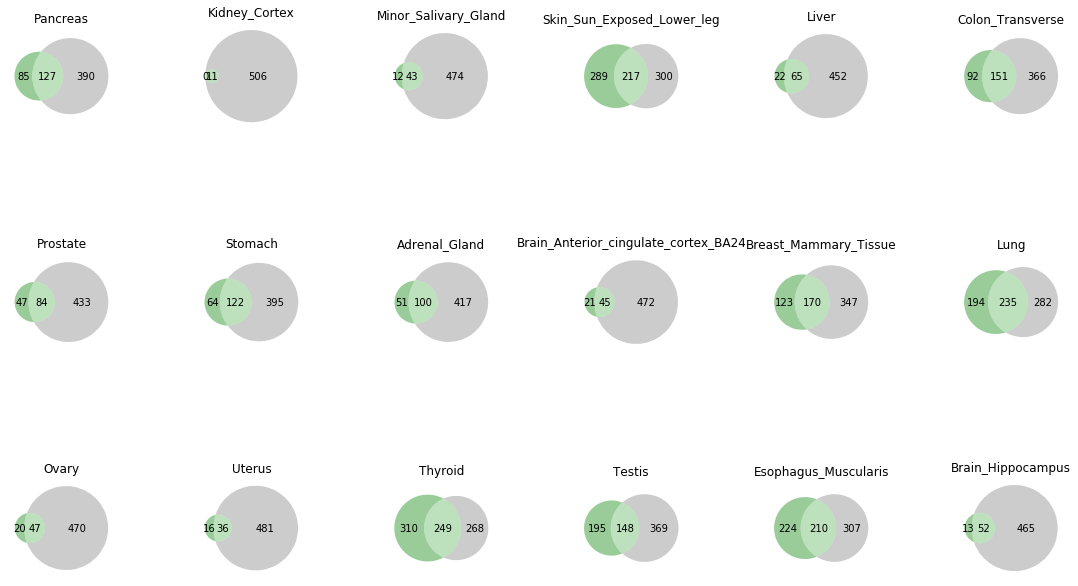

In [61]:
fig, axs = plt.subplots(3, 6, sharey=True, tight_layout=True, figsize=(15, 10))
axli = axs.flatten()

for i,y in enumerate([x for x in set(gtex_tissues)]):
    print(y)
    venn2([set(overlap[overlap["cell"]==y]["assoc"].tolist()),set(overlap[overlap["cell"]=="Whole_Blood"]["assoc"].tolist())],
     set_labels=("",""), set_colors=["green","gray"],ax=axli[i])
    axli[i].title.set_text(y)
plt.show()

In [63]:
snps=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/snp-tables/immune-microenvironment-nonhla.tsv",delimiter="\t")

In [64]:
snps

,snps,file,category,maf,variant,rsid,tpm beta,tpm SE,tpm P,REF,ALT,firebrowse beta,firebrowse SE,firebrowse P,pancan beta,pancan SE,pancan P,p-value,cis tss,gwas
0,19:7789796:T:C,CD209,cell type,0.25930,chr19:g.7789796T>C,rs10422720,-0.153826,0.018988,6.358100e-16,T,C,-0.174974,0.019221,1.126740e-19,-0.178179,0.018876,4.971470e-21,4.971470e-21,15084.0,['Blood protein levels']
1,19:7768298:A:G,CD209,cell type,0.15010,chr19:g.7768298A>G,rs58901714,-0.143563,0.023409,9.105090e-10,A,G,-0.157023,0.023889,5.293960e-11,-0.151253,0.023379,1.047650e-10,5.293960e-11,36582.0,NaN
2,3:159633885:T:C,CD209,cell type,0.01491,chr3:g.159633885T>C,rs76992466,-0.374997,0.068493,4.525630e-08,T,C,-0.340604,0.070042,1.182550e-06,-0.353152,0.068943,3.096210e-07,4.525630e-08,NaN,NaN
3,1:161508763:T:C,FCGR3B,cell type,0.36810,chr1:g.161508763T>C,rs10919544,0.166431,0.017210,5.489110e-22,T,C,0.237579,0.017299,2.300510e-42,0.236799,0.016959,9.737500e-44,9.737500e-44,84224.0,"['Takayasu arteritis', 'Blood protein levels']"
4,1:161572353:T:C,FCGR3B,cell type,0.14500,chr1:g.161572353T>C,rs67775399,-0.136145,0.023202,4.615400e-09,T,C,-0.166241,0.023540,1.799250e-12,-0.163998,0.023030,1.174700e-12,1.174700e-12,20634.0,"['Blood protein levels', 'Offspring birth weig..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477,5:96228072:C:T,ERAP1,antigen present,0.03280,chr5:g.96228072C>T,rs75263594,0.314825,0.046740,1.759080e-11,C,T,0.415443,0.047087,1.394430e-18,0.441081,0.045959,1.108240e-21,1.108240e-21,-117885.0,NaN
478,19:52151750:C:T,SIGLEC5,cell type,0.02647,chr19:g.52151750C>T,rs138816179,-0.426090,0.051681,1.955820e-16,C,T,-0.271523,0.053179,3.382250e-07,-0.282401,0.051787,5.115210e-08,1.955820e-16,-36995.0,NaN
479,3:47672891:T:C,TREX1,antigen present,0.34310,chr3:g.47672891T>C,rs1568691,0.108833,0.017492,5.189550e-10,T,C,0.101138,0.017753,1.268690e-08,0.108484,0.017414,4.936200e-10,4.936200e-10,834027.0,NaN
480,3:48343261:G:A,TREX1,antigen present,0.29480,chr3:g.48343261G>A,rs34630841,-0.124618,0.018304,1.068290e-11,G,A,-0.106043,0.018541,1.112900e-08,-0.106346,0.018229,5.646740e-09,1.068290e-11,163657.0,['Medication use (agents acting on the renin-a...


In [65]:
blood_snps=compiled_cis[(compiled_cis["cell"]=="Whole_Blood")&(compiled_cis["gtex gene"].isin(snps["file"].tolist()))]

In [67]:
brca_snps=compiled_cis[(compiled_cis["cell"]=="Breast_Mammary_Tissue")&(compiled_cis["gtex gene"].isin(snps["file"].tolist()))]

In [70]:
set([x for x in blood_snps["gtex gene"] if x not in brca_snps["gtex gene"].tolist()])

{'ALOX5AP',
 'B2M',
 'FAM167A',
 'FCGR2B',
 'ITGB2',
 'LILRB2',
 'LILRB4',
 'LNPEP',
 'MNDA',
 'OAS1',
 'OAS3',
 'SH3BP5L',
 'VAMP3'}

In [71]:
set([x for x in brca_snps["gtex gene"] if x not in blood_snps["gtex gene"].tolist()])

{'AMPD3', 'COX17', 'DBNDD1', 'GPLD1', 'HAUS1', 'IL2RA', 'MARCH1', 'TLR2'}

## Get QQ plot of GTEx cis snps

In [74]:
def compile_gtex(directory,file_name,mapping):
    gtex_files=[x for x in os.listdir(directory)]
    total_gtex=pd.DataFrame()

    for x in gtex_files:
        cis=pd.read_csv(directory+x)
        cis["file"]=x.split(file_name)[0]
        total_gtex=total_gtex.append(cis)
    
    #format variant2 and gene
    total_gtex["variant2"]=total_gtex["variant_b37"].str.split("_").str[0]+":"+total_gtex["variant_b37"].str.split("_").str[1]+":"+total_gtex["variant_b37"].str.split("_").str[3]+":"+total_gtex["variant_b37"].str.split("_").str[2]
    #get gene ids for mapping
    total_gtex["gene_id"]=total_gtex["phenotype_id"].str.split(".").str[0]
    
    total_gtex["ref"]=total_gtex["variant_id"].str.split("_").str[2]
    total_gtex["alt"]=total_gtex["variant_id"].str.split("_").str[3]
    
    total_gtex_melt=pd.melt(total_gtex, id_vars=(["gene_id","slope","slope_se","ref","alt","file","pval_nominal","maf","tss_distance","variant_b37"]),value_vars=(["variant","variant2"]))
    
    total_gtex_melt["gene_name"]=total_gtex_melt["gene_id"].map(mapping)
    
    total_gtex_melt["assoc"]=total_gtex_melt["value"]+"_"+total_gtex_melt["gene_name"]
    
    return(total_gtex_melt)

In [75]:
gtex=compile_gtex("./extracted_snps/",".gtex.cis.eur.snps.csv",ensembl_dict)

In [76]:
df_gtex_cis=gtex[gtex["assoc"].isin(gtex_cis)]

In [77]:
len(df_gtex_cis["assoc"].unique())

171

In [78]:
tpm_cancer=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/snp-tables/brian-cancer-type-beta-se.tsv",delimiter="\t")
firebrowse_cancer=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/snp-tables/firebrowse-cancer-type-beta-se.tsv",delimiter="\t")
pancanatlas_cancer=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/snp-tables/pancanatlas-cancer-type-beta-se.tsv",delimiter="\t")

In [79]:
compare_beta=pd.merge(df_gtex_cis,tpm_cancer,on="assoc")
compare_beta["combo"]=compare_beta["file"]+"."+compare_beta["file_name"]

In [80]:
combos=['Kidney_Cortex.KICH',
 'Kidney_Cortex.KIRC',
 'Kidney_Cortex.KIRP',
 'Testis.TGCT',
 'Brain_Hippocampus.GBM',
 'Skin_Sun_Exposed_Lower_leg.SKCM',
 'Ovary.OV',
 'Colon_Transverse.COAD',
 'Adrenal_Gland.ACC',
 'Pancreas.PAAD',
 'Esophagus_Muscularis.ESCA',
 'Stomach.STAD',
 'Thyroid.THCA',
 'Breast_Mammary_Tissue.BRCA',
 'Minor_Salivary_Gland.HNSC',
 'Brain_Anterior_cingulate_cortex_BA24.LGG',
 'Liver.LIHC',
 'Prostate.PRAD',
 'Uterus.UCEC',
 'Lung.LUAD',
 'Lung.LUSC']

In [81]:
compare_beta=compare_beta[compare_beta["combo"].isin(combos)]

In [82]:
compare_beta.head()

,gene_id,slope,slope_se,ref,alt,file,pval_nominal,maf,tss_distance,variant_b37,...,A1,TEST,OBS_CT,BETA,SE,T_STAT,P,ERRCODE,pheno,combo
99,ENSG00000049245,0.230936,0.103450,G,A,Kidney_Cortex,3.061431e-02,0.176923,10001,1_7841330_G_A_b37,...,A,ADD,55,-0.078666,0.366049,-0.214906,0.830906,.,VAMP3,Kidney_Cortex.KICH
100,ENSG00000049245,0.230936,0.103450,G,A,Kidney_Cortex,3.061431e-02,0.176923,10001,1_7841330_G_A_b37,...,A,ADD,418,0.182127,0.111590,1.632110,0.103436,.,VAMP3,Kidney_Cortex.KIRC
101,ENSG00000049245,0.230936,0.103450,G,A,Kidney_Cortex,3.061431e-02,0.176923,10001,1_7841330_G_A_b37,...,A,ADD,204,0.194364,0.156992,1.238050,0.217225,.,VAMP3,Kidney_Cortex.KIRP
145,ENSG00000049245,0.154947,0.031240,G,A,Testis,1.417909e-06,0.132353,10001,1_7841330_G_A_b37,...,A,ADD,108,0.112593,0.223966,0.502725,0.616321,.,VAMP3,Testis.TGCT
247,ENSG00000049245,0.289008,0.037165,G,A,Brain_Hippocampus,4.309925e-12,0.130000,10001,1_7841330_G_A_b37,...,A,ADD,121,0.465647,0.233285,1.996050,0.048469,.,VAMP3,Brain_Hippocampus.GBM


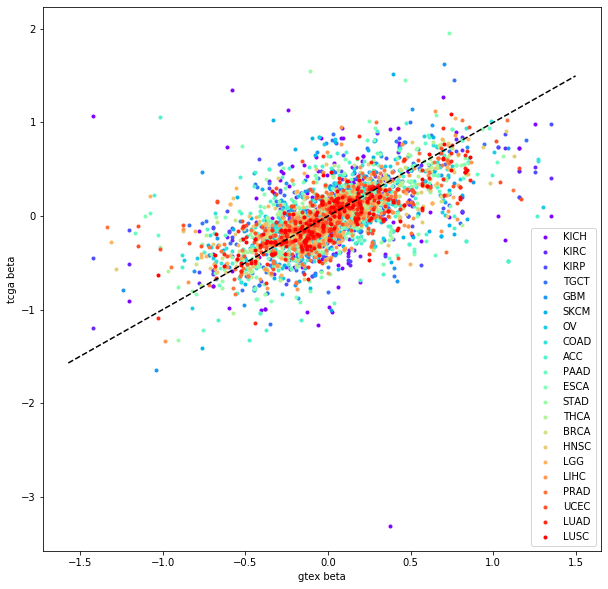

In [83]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

n=compare_beta["file_name"].unique()
color=iter(cm.rainbow(np.linspace(0,1,len(n))))

for x in n:
    c=next(color)
    canc_filt_dev=compare_beta[compare_beta["file_name"]==x]
    plt.scatter(canc_filt_dev["slope"],canc_filt_dev["BETA"],color=c,marker=".",label=x)


ax.set_xlabel("gtex beta")
ax.plot([ax.get_xlim()[0],ax.get_xlim()[1]], [ax.get_xlim()[0],ax.get_xlim()[1]], ls="--", c="k")
ax.set_ylabel("tcga beta")
plt.legend()
fig.savefig('gtex.beta.pdf')

## Get cell types of trans associations

In [120]:
gff3=pd.read_csv("/cellar/users/mpagadal/Data/resources/annotations/gencode.v19.annotation.gff3",delimiter="\t",header=None,comment="#")
gff3.head()

,0,1,2,3,4,5,6,7,8
0,chr1,HAVANA,gene,11869,14412,.,+,.,ID=ENSG00000223972.4;gene_id=ENSG00000223972.4...
1,chr1,HAVANA,transcript,11869,14409,.,+,.,ID=ENST00000456328.2;Parent=ENSG00000223972.4;...
2,chr1,HAVANA,exon,11869,12227,.,+,.,ID=exon:ENST00000456328.2:1;Parent=ENST0000045...
3,chr1,HAVANA,exon,12613,12721,.,+,.,ID=exon:ENST00000456328.2:2;Parent=ENST0000045...
4,chr1,HAVANA,exon,13221,14409,.,+,.,ID=exon:ENST00000456328.2:3;Parent=ENST0000045...


In [121]:
gff3["ID"]=gff3[8].str.split("gene_id=").str[1].str.split(";").str[0]
gff3["type"]=gff3[8].str.split("gene_type=").str[1].str.split(";").str[0]

In [122]:
gff3["ID"]=gff3["ID"].str.split(".").str[0]

In [123]:
mp_type=dict(zip(gff3["ID"],gff3["type"]))

In [124]:
gtex_trans=gtex_assoc[gtex_assoc["assoc"].isin(trans)]

In [127]:
gtex_trans["type"]=gtex_trans["gene_id"].map(mp_type)

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [128]:
gtex_trans=gtex_trans[~(gtex_trans["gtex gene"].isnull())]

In [131]:
gtex_trans=gtex_trans[~gtex_trans["gtex gene"].isnull()]

In [132]:
len(gtex_trans["assoc"].unique())

42

In [133]:
df_pie=gtex_trans[["assoc","gene_id","type"]].drop_duplicates()["type"].value_counts()

In [134]:
df_pie=df_pie.reset_index()
df_pie

,index,type
0,protein_coding,142
1,pseudogene,44
2,lincRNA,38
3,processed_transcript,7
4,antisense,7
5,sense_intronic,2
6,sense_overlapping,1


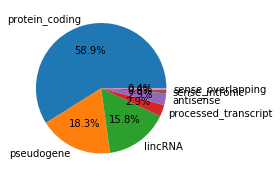

In [135]:
f=plt.figure(figsize=(3,3))
labels = df_pie["index"].tolist()
sizes = df_pie["type"].tolist()
plt.pie(sizes,labels=labels,autopct='%1.1f%%')
f.savefig("./plots/pie.type.pdf")